# Web Scraping for Job Posting Data:
_Author: Matěj Srna_
***
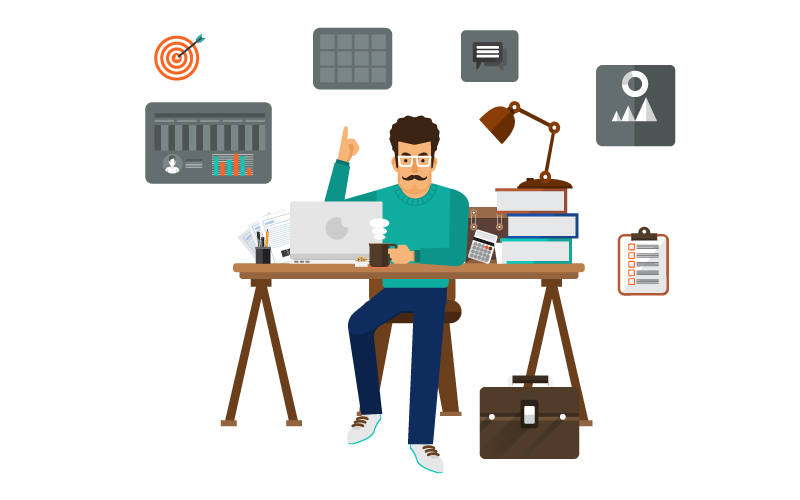
 
> _**Disclaimer: This Web Scraping is only used for the educational purposes**_

#### Content:
1. [Module imports](#Module-imports:)
2. [List of http links to jobs](#List-of-http-links-to-jobs:)
3. [Data scraping from the list of links](#Data-scraping-from-the-list-of-links:)
4. [Creation of CSV file out of web scraping](#Creation-of-CSV-file-out-of-web-scraping:)
5. [Creation of summary CSV file out of all CSV files](#Creation-of-summary-CSV-file-out-of-all-CSV-files:)

### Module imports:

***
For this analysis, I had to import several libraries. Mainly I used BeautifulSoup this library uses a parser to help navigate and search for the key elements which I specified to get the necessary data.

Secondly, I used pandas which are best for the data structuring. I used it to structure the data into DataFrame and also to save the data into CSV files.

Then I used the request library to get data from the websites I decided to use this library to avoid the issues with JavaScript.

Lastly, I used the DateTime library to import the actual date of scraping, the time library to slow down the speed of scraping, and the glob library to easily use paths to the files.
***

In [15]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
from datetime import date
from time import sleep
import glob
import numpy as np

## List of http links to jobs:

***
Here is the list of 4 links to the search pages. Each page contains 25 job postings. This is the limitation of LinkedIn, therefore I used this list to iterate and get the links to actual job postings. As you can see, at the end of each link there is __*"&start="*__ with number specification. Each page contains 25 jobs. In the list called links should be up to 100 links to the job posts.
***

In [16]:
link_browser = ["https://www.linkedin.com/jobs/search/?f_WT=3&keywords=data%20scientist&location=%C4%8Desko", 
                "https://www.linkedin.com/jobs/search/?f_WT=3&keywords=data%20scientist&location=%C4%8Desko&start=25", 
                "https://www.linkedin.com/jobs/search/?f_WT=3&keywords=data%20scientist&location=%C4%8Desko&start=50", 
                "https://www.linkedin.com/jobs/search/?f_WT=3&keywords=data%20scientist&location=%C4%8Desko&start=75"]

In [17]:
size_of_list = len(link_browser)

links = []

for n in range(size_of_list):
    response = requests.get(link_browser[n])
    html_text = response.text
    soup = BeautifulSoup(html_text, "html.parser")
    hrefs = soup.find_all("a", class_= "base-card__full-link absolute top-0 right-0 bottom-0 left-0 p-0 z-[2]")
    for n in hrefs:
        links.append(n["href"])

In [18]:
#print(links)

## Data scraping from the list of links:

***
This part of the code consists of several parts:
 * Creation of dictionary which specifies column names with lists as values
 * Looping through each link searching for the element on the website 
 * Appending the searched information to the dictionary's lists 

***

In [ ]:
size_of_list = len(links)
print("In process...")

d = {
    "name": [],
    "company_name": [],
    "ago": [],
    "contract": [],
    "location": [],
    "date": [],
    "description": [],
    "link": [],
    }

for n in range(size_of_list):
    #print(n, links[n])
    response = requests.get(links[n])
    html_text = response.text
    
    #print(links[n])  
    
    soup = BeautifulSoup(html_text, "html.parser")
    try:
        name_s = soup.find("div", class_ ="top-card-layout__entity-info-container flex flex-wrap papabear:flex-nowrap")
        name_s = name_s.find("h1", class_="top-card-layout__title font-sans text-lg papabear:text-xl font-bold leading-open text-color-text mb-0 topcard__title")
    except:
        name_s = soup.find("div", class_ ="top-card-layout__card relative p-2 papabear:p-details-container-padding")
        name_s = name_s.find("div", class_="top-card-layout__entity-info flex-grow flex-shrink-0 basis-0 babybear:flex-none babybear:w-full babybear:flex-none babybear:w-full")
        #name_s = name_s.find("h1", class_="top-card-layout__title font-sans text-lg papabear:text-xl font-bold leading-open text-color-text mb-0 topcard__title")
        
    com_name_s = soup.find("span", class_ ="topcard__flavor")
    time_s = soup.find("span", class_="posted-time-ago__text topcard__flavor--metadata")
    description_s = soup.find("div", class_= "show-more-less-html__markup show-more-less-html__markup--clamp-after-5") 
    contract_s = soup.find("span", class_="description__job-criteria-text description__job-criteria-text--criteria")
    location_s = soup.find("span", class_="topcard__flavor topcard__flavor--bullet")
    try:
        salary_s = soup.find("div", class_="salary compensation__salary")
    except:
        pass
    
    try:
        name = name_s.text.strip().replace("++", "+")
    except:
        name = name_s.get_text.strip().replace("++", "+")
    company_name = com_name_s.text.strip()
    try:
        ago = time_s.get_text().strip()
    except:
        time_s = soup.find("span", class_="posted-time-ago__text posted-time-ago__text--new topcard__flavor--metadata")
        ago = time_s.get_text().strip()
    description = description_s.text.strip()
    date = date.today()
    contract = contract_s.text.strip()
    location = location_s.text.strip()
    try:
        salary = salary_s.text.strip()
    except:
        pass
      
    d["name"].append(name)
    d["company_name"].append(company_name)
    d["ago"].append(ago)
    d["contract"].append(contract)
    d["description"].append(description)
    d["date"].append(date)
    d["link"].append(links[n])
    d["location"].append(location)
    #try:
    #    print(salary)
    #except:
    #    pass
    
    
    sleep(2)
    
    #print(name)
    #print(ago)
    #print(n, links[n])
print(f"Done: {n + 1} / {size_of_list}")

In process...


## Creation of CSV file out of web scraping: 
***
Here I create the separated CSV files with data created by the Pandas library. Each scraping is saved into a separate file with the date included in the file name. Therefore I can keep the data separated in case of any error and I can easily restore the data. 
***

In [ ]:
data = pd.DataFrame.from_dict(data=d, orient='index')
data = data.transpose()

data.to_csv(f"RAW_DATA/scraped_data_{date}.csv", index=False)

## Creation of summary CSV file out of all CSV files:
***
In this part of the code, I merge all the CSV files which have been already scraped. For further analysis and Data cleaning, I needed to put all the data into one file. For this I use Pandas DataFrame. 
***

In [ ]:
# get data file names
path =r"C:\Users\srnam\PycharmProjects\data_analyz_pandas\LinkedIn_job_analysis\RAW_DATA"
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)
big_frame.to_csv("DATA/summary_data.csv", index=False)
big_frame.shape

In [ ]:
#s = soup.find()
#print(s)